<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/Reward_Analysis_Exp3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting Reward Analysis Experiment...

🧠 Training: 1. The Optimal ...
🧠 Training: 2. The Wanderer ...
🧠 Training: 3. The Quitter ...

✅ All agents trained! Generating comparison plot...


/tmp/ipython-input-1155930347.py:142: UserWarning: Glyph 128371 (\N{HOLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1155930347.py:142: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


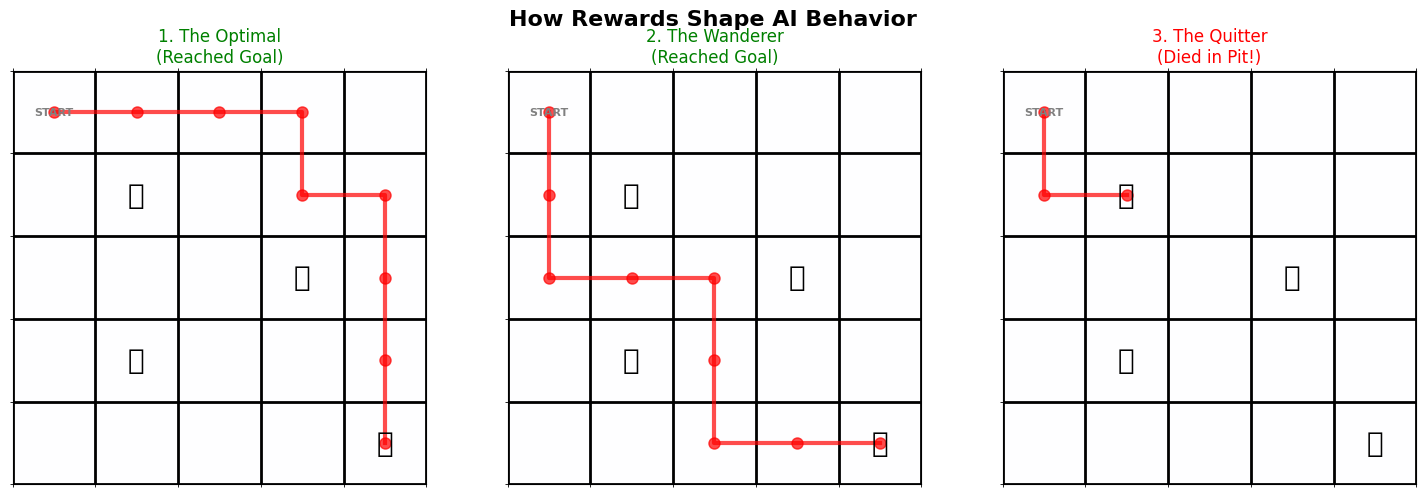

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import random

# =====================================================================
# 🎓 STUDENT EXPERIMENT SETTINGS: REWARD ANALYSIS 🎓
# =====================================================================
GRID_SIZE = 5           # A 5x5 grid
EPISODES = 500          # Number of training attempts
ALPHA = 0.5             # Learning Rate
GAMMA = 0.9             # Discount Factor
EPSILON = 0.2           # Exploration Rate (20% chance to wander)

# We define 3 different "Personalities" based entirely on their reward structures!
REWARD_PROFILES = {
    "1. The Optimal": {"goal": 10.0, "pit": -10.0, "step": -1.0}, # Standard
    "2. The Wanderer": {"goal": 10.0, "pit": -10.0, "step": 0.0},  # No time pressure
    "3. The Quitter":  {"goal": 10.0, "pit": -5.0,  "step": -10.0} # Hates taking steps more than pits!
}
# =====================================================================

# 1. Build Our Own Custom Environment
class CustomGridEnv:
    """
    A custom grid world where the agent must avoid pits to reach the goal.
    Coordinates are (row, column). Top-Left is (0,0).
    """
    def __init__(self, size=GRID_SIZE, goal_reward=10.0, pit_reward=-10.0, step_reward=-1.0):
        self.size = size
        self.start_pos = (0, 0)                 # Top-Left
        self.goal_pos = (size - 1, size - 1)    # Bottom-Right

        # Dynamic Rewards applied from our experiment settings
        self.goal_reward = goal_reward
        self.pit_reward = pit_reward
        self.step_reward = step_reward

        # Add some dangerous pits the agent must learn to avoid!
        self.pits = [(1, 1), (2, 3), (3, 1)]

        self.state_pos = self.start_pos

    def _get_state_id(self, pos):
        """Converts a 2D (row, col) coordinate into a 1D state ID for the Q-Table."""
        return pos[0] * self.size + pos[1]

    def reset(self):
        """Put the agent back at the start."""
        self.state_pos = self.start_pos
        return self._get_state_id(self.state_pos)

    def step(self, action):
        """Move the agent and calculate rewards."""
        r, c = self.state_pos

        # Apply movement logic
        if action == 0: r = max(0, r - 1)               # 0: UP
        elif action == 1: c = min(self.size - 1, c + 1) # 1: RIGHT
        elif action == 2: r = min(self.size - 1, r + 1) # 2: DOWN
        elif action == 3: c = max(0, c - 1)             # 3: LEFT

        self.state_pos = (r, c)
        state_id = self._get_state_id(self.state_pos)

        # Check what happened after the move
        if self.state_pos == self.goal_pos:
            return state_id, self.goal_reward, True
        elif self.state_pos in self.pits:
            return state_id, self.pit_reward, True
        else:
            return state_id, self.step_reward, False

# 2. Build the Simple Q-Learning Agent
class SimpleAgent:
    def __init__(self, n_states, n_actions):
        self.n_actions = n_actions
        self.q_table = np.zeros((n_states, n_actions))

    def choose_action(self, state, epsilon):
        """Epsilon-Greedy choice: explore or exploit."""
        if random.uniform(0, 1) < epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            # Break ties randomly to prevent getting stuck early on
            max_q = np.max(self.q_table[state, :])
            best_actions = np.where(self.q_table[state, :] == max_q)[0]
            return random.choice(best_actions)

    def learn(self, state, action, reward, next_state):
        """Q-Learning Update Rule"""
        current_q = self.q_table[state, action]
        max_future_q = np.max(self.q_table[next_state, :])

        # Calculate new value
        new_q = current_q + ALPHA * (reward + GAMMA * max_future_q - current_q)
        self.q_table[state, action] = new_q

# 3. Visualization Code for Comparison
def plot_reward_analysis(results, env_size, pits, goal_pos, start_pos):
    """Plots the paths of multiple agents side-by-side for comparison."""
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    fig.suptitle("How Rewards Shape AI Behavior", fontsize=16, weight='bold')

    for ax, (profile_name, path) in zip(axes, results.items()):
        # Create a blank white grid
        grid_visual = np.zeros((env_size, env_size))
        ax.matshow(grid_visual, cmap='Blues', alpha=0.1)

        # Draw grid elements
        for r in range(env_size):
            for c in range(env_size):
                pos = (r, c)
                if pos in pits:
                    ax.text(c, r, "🕳️", va='center', ha='center', fontsize=20)
                elif pos == goal_pos:
                    ax.text(c, r, "🏁", va='center', ha='center', fontsize=20)
                elif pos == start_pos:
                    ax.text(c, r, "START", va='center', ha='center', color='gray', fontsize=8, weight='bold')

        # Draw the path taken by this agent
        if path:
            y_coords = [p[0] for p in path]
            x_coords = [p[1] for p in path]
            ax.plot(x_coords, y_coords, color='red', linewidth=3, marker='o', markersize=8, alpha=0.7)

            # Mark ending state
            end_pos = path[-1]
            if end_pos in pits:
                ax.set_title(f"{profile_name}\n(Died in Pit!)", color='red')
            elif end_pos == goal_pos:
                ax.set_title(f"{profile_name}\n(Reached Goal)", color='green')
            else:
                ax.set_title(f"{profile_name}\n(Wandered Endlessly)", color='orange')

        ax.set_xticks(np.arange(-0.5, env_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, env_size, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    display(fig)
    plt.close(fig)

# =====================================================================
# 🚀 MAIN EXECUTION
# =====================================================================
if __name__ == "__main__":
    print("🚀 Starting Reward Analysis Experiment...\n")

    results = {} # Store the paths taken by each personality

    for profile_name, rewards in REWARD_PROFILES.items():
        print(f"🧠 Training: {profile_name} ...")

        # Create environment with this specific reward profile
        env = CustomGridEnv(
            size=GRID_SIZE,
            goal_reward=rewards["goal"],
            pit_reward=rewards["pit"],
            step_reward=rewards["step"]
        )

        agent = SimpleAgent(n_states=env.size * env.size, n_actions=4)

        # --- TRAINING LOOP ---
        for episode in range(EPISODES):
            state = env.reset()
            done = False

            while not done:
                action = agent.choose_action(state, EPSILON)
                next_state, reward, done = env.step(action)
                agent.learn(state, action, reward, next_state)
                state = next_state

        # --- TESTING LOOP ---
        env.reset()
        state = env._get_state_id(env.start_pos)
        path = [env.start_pos]
        done = False
        step_count = 0

        while not done and step_count < 30: # Max 30 steps to prevent infinite wandering
            action = agent.choose_action(state, epsilon=0.0)
            next_state, reward, done = env.step(action)
            path.append(env.state_pos)
            state = next_state
            step_count += 1

        results[profile_name] = path

    print("\n✅ All agents trained! Generating comparison plot...")
    plot_reward_analysis(results, GRID_SIZE, env.pits, env.goal_pos, env.start_pos)